# **Customer-Support-ML-SQL**

---



# Dataset loaded

In [1]:
csv_path = "/mnt/data/customer_support_tickets.csv"

In [24]:
# 2. Imports & basic load
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# load
data = pd.read_csv("/content/customer_support_tickets.csv")
print("Loaded rows,cols:", data.shape)
data.head()

# Save the loaded data to a CSV file
data.to_csv("loaded_customer_support_tickets.csv", index=False)
print("Saved loaded data to loaded_customer_support_tickets.csv")

Loaded rows,cols: (8469, 17)
Saved loaded data to loaded_customer_support_tickets.csv


# Basic cleaning

In [5]:
# 3. Quick info & basic checks
data.info()
data.describe(include='all').T
# check missing
data.isna().sum().sort_values(ascending=False).head(15)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8469 entries, 0 to 8468
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Ticket ID                     8469 non-null   int64  
 1   Customer Name                 8469 non-null   object 
 2   Customer Email                8469 non-null   object 
 3   Customer Age                  8469 non-null   int64  
 4   Customer Gender               8469 non-null   object 
 5   Product Purchased             8469 non-null   object 
 6   Date of Purchase              8469 non-null   object 
 7   Ticket Type                   8469 non-null   object 
 8   Ticket Subject                8469 non-null   object 
 9   Ticket Description            8469 non-null   object 
 10  Ticket Status                 8469 non-null   object 
 11  Resolution                    2769 non-null   object 
 12  Ticket Priority               8469 non-null   object 
 13  Tic

,0
Customer Satisfaction Rating,5700
Resolution,5700
Time to Resolution,5700
First Response Time,2819
Ticket ID,0
Customer Name,0
Customer Email,0
Customer Age,0
Customer Gender,0
Ticket Subject,0


In [7]:
 # Simple cleaning
if 'Date of Purchase' in data.columns:
    data['Date of Purchase'] = pd.to_datetime(data['Date of Purchase'], errors='coerce')

df = data.copy()

if 'Customer Satisfaction Rating' in df.columns:
    df['Customer Satisfaction Rating'] = df['Customer Satisfaction Rating'].fillna(-1)

if 'Ticket Description' in df.columns:
    df = df[df['Ticket Description'].notna()]

print("After base cleaning:", df.shape)

After base cleaning: (8469, 17)


# EDA

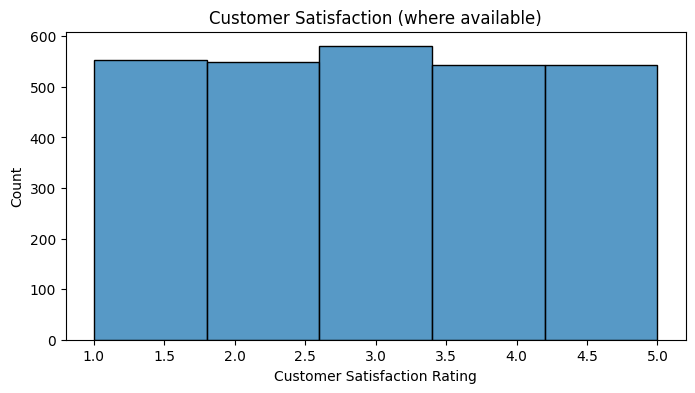

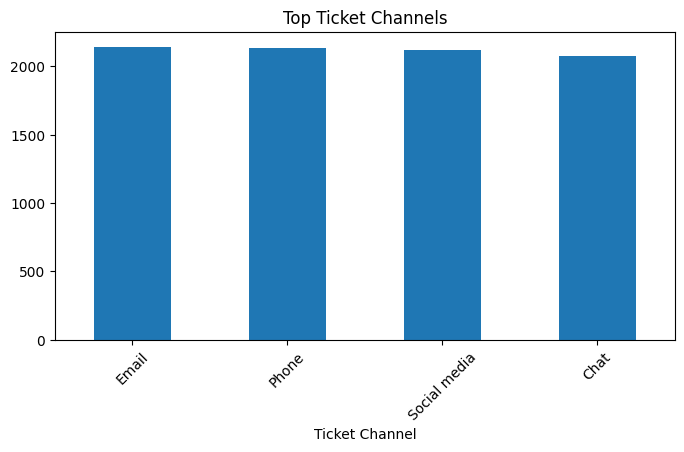

In [8]:
# 5. Simple EDA (a few plots)
plt.figure(figsize=(8,4))
if 'Customer Satisfaction Rating' in df.columns:
    sns.histplot(df[df['Customer Satisfaction Rating']!=-1]['Customer Satisfaction Rating'], bins=5, kde=False)
    plt.title('Customer Satisfaction (where available)')
    plt.show()

# ticket channel bar
if 'Ticket Channel' in df.columns:
    plt.figure(figsize=(8,4))
    df['Ticket Channel'].value_counts().head(10).plot(kind='bar')
    plt.title('Top Ticket Channels')
    plt.xticks(rotation=45)
    plt.show()

# ML baseline model

In [9]:
# 6. Quick feature encoding for a tiny ML baseline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

if 'Customer Satisfaction Rating' in df.columns:
    df_ml = df[df['Customer Satisfaction Rating']!=-1].copy()
    df_ml['satisfied'] = (df_ml['Customer Satisfaction Rating'] >= 4).astype(int)

    features = []
    if 'Customer Age' in df_ml.columns:
        features.append('Customer Age')
    if 'Ticket Priority' in df_ml.columns:
        df_ml['Ticket Priority_enc'] = df_ml['Ticket Priority'].astype('category').cat.codes
        features.append('Ticket Priority_enc')
    if 'Ticket Channel' in df_ml.columns:
        df_ml['Ticket Channel_enc'] = df_ml['Ticket Channel'].astype('category').cat.codes
        features.append('Ticket Channel_enc')

    if not features and 'Ticket Type' in df_ml.columns:
        df_ml = pd.get_dummies(df_ml, columns=['Ticket Type'], prefix='TT', drop_first=True)
        features = [c for c in df_ml.columns if c.startswith('TT_')][:6]  # pick up to 6

    if features:
        X = df_ml[features].fillna(-1)
        y = df_ml['satisfied']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
        model = RandomForestClassifier(n_estimators=50, random_state=42)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        print("Accuracy:", accuracy_score(y_test, preds))
        print(classification_report(y_test, preds))
    else:
        print("Not enough simple features to run ML baseline (no numeric/categorical columns found).")
else:
    print("No Customer Satisfaction column present to train on.")

Accuracy: 0.5281385281385281
              precision    recall  f1-score   support

           0       0.62      0.62      0.62       434
           1       0.37      0.37      0.37       259

    accuracy                           0.53       693
   macro avg       0.50      0.50      0.50       693
weighted avg       0.53      0.53      0.53       693



# SQL integration

In [11]:
# 7. SQL: using sqlite (load CSV into sqlite and run simple SQL queries)
import sqlite3

conn = sqlite3.connect('tickets.db')
df.to_sql('tickets', conn, if_exists='replace', index=False)
print("Table 'tickets' written. Example queries below:")


q1 = "SELECT COUNT(*) as total_tickets FROM tickets;"
q2 = "SELECT \"Ticket Channel\", COUNT(*) as cnt FROM tickets GROUP BY \"Ticket Channel\" ORDER BY cnt DESC LIMIT 10;"
q3 = "SELECT AVG(`Customer Age`) as avg_age FROM tickets WHERE `Customer Satisfaction Rating` IS NOT NULL;"

for q in (q1,q2,q3):
    print("---", q)
    print(pd.read_sql(q, conn).head())

Table 'tickets' written. Example queries below:
--- SELECT COUNT(*) as total_tickets FROM tickets;
   total_tickets
0           8469
--- SELECT "Ticket Channel", COUNT(*) as cnt FROM tickets GROUP BY "Ticket Channel" ORDER BY cnt DESC LIMIT 10;
  Ticket Channel   cnt
0          Email  2143
1          Phone  2132
2   Social media  2121
3           Chat  2073
--- SELECT AVG(`Customer Age`) as avg_age FROM tickets WHERE `Customer Satisfaction Rating` IS NOT NULL;
     avg_age
0  44.026804


In [13]:
# 8. SQL with pandasql (optional, inline SQL over pandas)
!pip install pandasql
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

# Example: top 5 frequent ticket subjects
q = "SELECT `Ticket Subject`, COUNT(*) as cnt FROM df GROUP BY `Ticket Subject` ORDER BY cnt DESC LIMIT 5;"
print(pysqldf(q))

  Preparing metadata (setup.py) ... done
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26773 sha256=86825b3e4ff698d850de333f48dedc0c63d6964e0e5e1569ebe8c752170089e5
  Stored in directory: /root/.cache/pip/wheels/15/a1/e7/6f92f295b5272ae5c02365e6b8fa19cb93f16a537090a1cf27
Successfully built pandasql
          Ticket Subject  cnt
0         Refund request  576
1           Software bug  574
2  Product compatibility  567
3       Delivery problem  561
4         Hardware issue  547


# CSV export

In [14]:
# 9. Save a small result back to CSV (if you want to download)
df.to_csv("/content/cleaned_customer_support_tickets_sample.csv", index=False)
print("Saved sample to /content/cleaned_customer_support_tickets_sample.csv")

Saved sample to /content/cleaned_customer_support_tickets_sample.csv


# Models Predict

In [16]:
df_ml = df[df['Customer Satisfaction Rating']!=-1].copy()
df_ml['satisfied'] = (df_ml['Customer Satisfaction Rating'] >= 4).astype(int)

# Basic features (you can add more later)
df_ml['Ticket Priority_enc'] = df_ml['Ticket Priority'].astype('category').cat.codes
df_ml['Ticket Channel_enc'] = df_ml['Ticket Channel'].astype('category').cat.codes

features = ['Customer Age', 'Ticket Priority_enc', 'Ticket Channel_enc']
X = df_ml[features].fillna(-1)
y = df_ml['satisfied']

# Logistic Regression

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

lr = LogisticRegression(max_iter=500)
lr.fit(X_train, y_train)

preds = lr.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, preds))
print(classification_report(y_test, preds))

Logistic Regression Accuracy: 0.6262626262626263
              precision    recall  f1-score   support

           0       0.63      1.00      0.77       434
           1       0.00      0.00      0.00       259

    accuracy                           0.63       693
   macro avg       0.31      0.50      0.39       693
weighted avg       0.39      0.63      0.48       693



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Improved Random Forest

In [20]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=12,
    random_state=42
)
rf.fit(X_train, y_train)

rf_preds = rf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, rf_preds))
print(classification_report(y_test, rf_preds))

Random Forest Accuracy: 0.5382395382395382
              precision    recall  f1-score   support

           0       0.62      0.67      0.64       434
           1       0.37      0.32      0.34       259

    accuracy                           0.54       693
   macro avg       0.49      0.49      0.49       693
weighted avg       0.53      0.54      0.53       693



# Gradient Boosting (XGBoost)

In [21]:
!pip install xgboost

from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    random_state=42
)

xgb.fit(X_train, y_train)

xgb_preds = xgb.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, xgb_preds))
print(classification_report(y_test, xgb_preds))

XGBoost Accuracy: 0.5584415584415584
              precision    recall  f1-score   support

           0       0.62      0.78      0.69       434
           1       0.34      0.19      0.25       259

    accuracy                           0.56       693
   macro avg       0.48      0.48      0.47       693
weighted avg       0.51      0.56      0.52       693



In [26]:
from google.colab import files

# Path of your cleaned CSV (change if needed)
cleaned_path = "/content/cleaned_customer_support_tickets_sample.csv"

# Download to your local machine
files.download(cleaned_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>